# **Parcial 2 TAM**

# **2.1 Modelos y optimizaciones**

* **2.1.1 Naive bayes**

El modelo del naive bayes asume que las caracteristicas de los datos son independientes entre si, dejando la probabilidad posterior como:
$$p(A,x) =  \prod_{j=1}^{P} p(x_j|A)p(A)$$

La optimización se hace por máximo a posteriori
$$\hat{y} = \arg\max_{c} \prod_{j=1}^{P} p(x_j \mid A_c) p(A_c)$$

maximizando la probabilidad de pertenencia a la clase A

* **2.1.2 Logistic Regresor**

El modelo Logistic Regression utiliza la funcion sigmoide para predecir la probabilidad de pertenencia a una clase; Esta dado por:
$$p(y=1 \mid \mathbf{x}) = \sigma(\mathbf{w}^\top \mathbf{x} + b) = \frac{1}{1 + \exp\left(-(\mathbf{w}^\top \mathbf{x} + b)\right)}$$
El problema de optimizacion se hace minimizando esa funcion logistica pero agregando un factor de regularizacion como normal L1 o L2
$$\hat{y} = \arg \min_{\mathbf{w}, b} \quad \sum_{i=1}^{N} \ln\left(1 + \exp\left(-y_i (\mathbf{w}^\top \mathbf{x}_i + b)\right)\right) + \lambda\, R(\mathbf{w})$$

* **2.1.3 Clasificador con SGD**

SGD signifca Stochastic gradient descent, este modelo es lineal:
$$f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x} + b$$
y su optimziacion depende de la funcion de costo seleccionada, podría ser la misma de logistic regressor, u otra como la hinge. En general:
$$\hat{y} = \arg\min_{\mathbf{w}, b} \quad \frac{1}{N} \sum_{i=1}^{N} L\Big(y_i, \mathbf{w}^\top \mathbf{x}_i + b\Big) + \lambda\, R(\mathbf{w})$$
Donde L representa una funcion de costo cualquiera que depende de los pesos, la entrada y el bias

* **2.1.4 Linear discriminant analysis**

Este modelo asume que todas las clases estan distribuidas por una funcion de probabilidad gaussiana que comparten matriz de covarianza, tienen distinta media pero igual varianza, y acomoda fornteras de descicion lineales. El modelo de los datos esta dado por la probabilidad gaussiana:
$$p(\mathbf{x}\mid y=k) = \frac{1}{(2\pi)^{d/2} \lvert \boldsymbol{\Sigma} \rvert^{1/2}} \exp\!\left(-\frac{1}{2} (\mathbf{x}-\boldsymbol{\mu}_k)^\top \boldsymbol{\Sigma}^{-1} (\mathbf{x}-\boldsymbol{\mu}_k)\right)$$
Con $\mu$ la media por clase, $\sigma$ la matriz de covarainza y d el numero de features.

La optimizacion se suele hacer maximizando la varianza entre clases relativo a la varianza interna de cada clase, lo que lleva al siguiente problema de valores propios:
$$\mathbf{S}_w^{-1}\mathbf{S}_b\, \mathbf{w} = \lambda\, \mathbf{w}$$

cn $S_w$ la matriz de dispersion interna de las clases, y $S_b$ la dispersion entre clases


* **2.1.5 K-Nearest Neighbors**

Al ser no parametrico no tiene un modelo explicito de los datos, clasifica por conteo de vecindades, y por esto mismo, se podria decir que el problema de optimizacion simplemente es maximizar el numero de vecinos de una clase para definir la pernencia a dicha clase.

* **2.1.6 Random Forest**

El modelo se basa en generar multiples arboles de decision, cada uno con subsets de datos e incluso de features. Cada arbol clasifica y despues se define la clase por voto mayoritario entre los arboles.

Cada arbol optimiza su descision maximizando la reduccion de "impurezas" en cada nodo, para definir la clase seleccionada, siguiendo:
$$\hat{y} = \arg \max_{\text{split}} \quad \Delta \text{Impurity} = \text{Impurity(parent)} - \left( \frac{N_{\text{left}}}{N} \, \text{Impurity(left)} + \frac{N_{\text{right}}}{N} \, \text{Impurity(right)} \right)$$

* **2.1.7 SVM classifier**

Al igual que en regresion, el modelo es lineal, aunque tiene una funcion $\phi$ de mapeo que puede ser no lineal (kernel)
$$f(\mathbf{x}) = \mathbf{w}^\top \phi(\mathbf{x}) + b$$

Este modelo busca maximizar la distancia entre clases optimizando la forntera de descion. 
$$\begin{aligned}
\min_{\mathbf{w}, b, \boldsymbol{\xi}} \quad & \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^{N} \xi_i \\
\text{subject to} \quad & y_i (\mathbf{w}^\top \phi(\mathbf{x}_i) + b) \geq 1 - \xi_i, \quad \xi_i \geq 0,\quad i=1,\dots,N
\end{aligned}$$

Donde $\xi_i$ ayuda a definir si el dato i viola la frontera de decision, y si esta o no bien clasificado

* **2.1.8 Gaussian Process Classifier**

Asumiendo un prior gaussiano
$$f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x}'))$$

Se supone una probabilidad de pertenencia a clase calculada por una funcion tipo logistic o probit:
$$p(y=1 \mid \mathbf{x}) = \sigma\big(f(\mathbf{x})\big)$$

para optimizar los hiperparametros del kernel de mapeo k, se maximiza la verosimilitud:
$$\hat{y} = \arg \max_{\theta} \quad \log \int p(\mathbf{y} \mid \mathbf{f})\, p(\mathbf{f} \mid \theta)\, d\mathbf{f}$$


# **2.2 Implementacion de modelos**

**Copiamos el preproceso del cuaderno guia (6_CVClasificacion_LFW.ipynb)**

In [1]:
#librerias a importar
import os
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = 100*confusion_matrix(y_true, y_pred,normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Class Prior Probabilities (Proportions):
[0.05512422 0.11180124 0.41149068 0.18322981 0.05978261 0.08462733
 0.0939441 ]
Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)


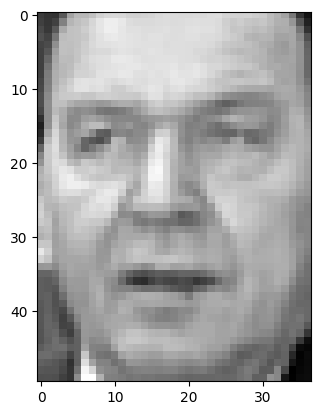

In [2]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
#Conteo de las imagenes para conocer el desbalance de datos
counter = Counter(lfw_people.target)
total_images = len(lfw_people.images)
#Visualizar el desbanlance
# Compute proportions
proportions = np.array([count / total_images for count in counter.values()])

# Print proportions
print("Class Prior Probabilities (Proportions):")
print(proportions)

# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

In [3]:
#Particion entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3, random_state=123)
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
510,0.000836,0.001143,0.001446,0.001666,0.001897,0.001994,0.002066,0.002071,0.002097,0.002138,...,0.000549,0.001384,0.002332,0.003189,0.003645,0.003727,0.003101,0.000856,0.000395,0.000466
1035,0.001589,0.001758,0.001922,0.002409,0.002819,0.002958,0.002917,0.002830,0.002830,0.002737,...,0.000297,0.000374,0.000384,0.000436,0.000359,0.000369,0.000420,0.000497,0.000466,0.000466
176,0.000892,0.001205,0.001210,0.001287,0.001492,0.001687,0.001763,0.001779,0.001845,0.001866,...,0.000451,0.000446,0.000482,0.000472,0.000477,0.000466,0.000513,0.000559,0.000600,0.000538
620,0.000267,0.000584,0.001446,0.002230,0.002507,0.002512,0.002491,0.002532,0.002584,0.002594,...,0.001333,0.001389,0.000723,0.000133,0.000190,0.000251,0.000313,0.000400,0.000549,0.000666
689,0.002261,0.002409,0.001958,0.001753,0.002127,0.002907,0.002932,0.002676,0.002655,0.002799,...,0.001569,0.001512,0.001548,0.001615,0.001794,0.002276,0.003106,0.003522,0.003573,0.003578


* **2.2.1 Implementación de los modelos con accuracy como score en el gridsearch**

In [4]:
#%% Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.linear_model import LogisticRegression as LR, SGDClassifier as SGDC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier as GPC
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import DotProduct
import joblib

#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', NB())], #Pipeline1
       [('nor', MinMaxScaler()),
        ('cla', LR())], #Pipeline2
       [('nor', MinMaxScaler()),
        ('cla', SGDC())], #Pipeline3
       [('nor', MinMaxScaler()),
        ('cla', LDA())], #Pipeline4
       [('nor', MinMaxScaler()),
        ('cla', KNC())], #Pipeline5
       [('nor', MinMaxScaler()),
        ('cla', RF())], #Pipeline6
       [('nor', MinMaxScaler()),
        ('cla', SVC())], #Pipeline7
       [('nor', MinMaxScaler()),
        ('cla', GPC())]#Pipeline8
      ]
#Para el SVC los diferentes kernels tienen diferentes hiperparametros
#linear kernel (only C and shrinking are relevant)
param_grid_svc_linear = {
    'cla__C': [0.001, 0.01, 0.1, 1],
    'cla__kernel': ['linear'],
    'cla__shrinking': [True, False]
}

#polynomial kernel (degree, gamma, and coef0 are relevant)
param_grid_svc_poly = {
    'cla__C': [0.001, 0.01, 0.1, 1],
    'cla__kernel': ['poly'],
    'cla__degree': [2, 3, 4, 5],
    'cla__gamma': ['auto', 0.01, 0.1, 1],
    'cla__coef0': [0.0, 0.1, 1.0],
    'cla__shrinking': [True, False]
}

#RBF kernel (gamma is relevant)
param_grid_svc_rbf = {
    'cla__C': [0.001, 0.01, 0.1, 1],
    'cla__kernel': ['rbf'],
    'cla__gamma': ['auto', 0.01, 0.1, 1],
    'cla__shrinking': [True, False]
}

#sigmoid kernel (gamma and coef0 are relevant)
param_grid_svc_sigmoid = {
    'cla__C': [0.001, 0.01, 0.1, 1],
    'cla__kernel': ['sigmoid'],
    'cla__gamma': [ 'auto', 0.01, 0.1, 1],
    'cla__coef0': [0.0, 0.1, 1.0],
    'cla__shrinking': [True, False]
}

#Se combinan
param_grid_svc = [
    param_grid_svc_linear,
    param_grid_svc_poly,
    param_grid_svc_rbf,
    param_grid_svc_sigmoid
]

parameters = [{
              'cla__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],#Pipeline1 - hiperparametros
              },
              {
                'cla__C': [0.01, 0.1, 1],
                'cla__penalty': ['elasticnet'],#En lugar de probar l1 y l2 directamente, se pone l1ratio a 0 y a 1 para que los pruebe dentro de elasticnet
                'cla__solver': ['saga'],
                'cla__class_weight': [None, 'balanced'],
                'cla__l1_ratio': [0, 0.2, 0.5, 0.7, 1] #Pipeline2 - hiperparametros 
              },                                                                            
              {
                'cla__loss': ['hinge', 'log_loss', 'modified_huber'],
                'cla__alpha': [1e-4, 1e-3, 1e-2],
                'cla__penalty': ['elasticnet'],
                'cla__l1_ratio': [0, 0.2, 0.5, 0.7, 1],#En lugar de probar l1 y l2 directamente, se pone l1ratio a 0 y a 1 para que los pruebe dentro de elasticnet
                'cla__learning_rate': ['constant', 'optimal', 'invscaling'],
                'cla__eta0': [0.001, 0.01, 0.1],
                'cla__class_weight': [None, 'balanced'] #Pipeline3 - hiperparametros
              },
              {
                'cla__solver': ['svd', 'lsqr', 'eigen'],
                'cla__shrinkage': [None, 'auto', 1e-3, 1e-2, 1e-1],  # Only applies for 'lsqr' or 'eigen'
                'cla__priors': [None, proportions],
                'cla__n_components': [None, 2, 5]#Pipeline 4 - hiperparametros
              },
              {
                'cla__n_neighbors': [5, 9, 15],
                'cla__weights': ['uniform', 'distance'],
                'cla__metric': ['minkowski'],
                'cla__p': [1, 2, 4], 
                'cla__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']#Pipeline 5 - hiperparametros
              },
              {
                'cla__n_estimators': [1, 25, 50],
                'cla__max_depth': [None, 1, 10],
                'cla__min_samples_split': [2, 10, 20],
                'cla__min_samples_leaf': [1, 5, 10],
                'cla__max_features': ['sqrt', 'log2', None],
                'cla__bootstrap': [True],
                'cla__criterion': ['gini', 'entropy']#Pipeline 6 - hiperparametros
              },
                 param_grid_svc,
              {
                'cla__kernel': [
                            C(1.0, (1e-4, 1e2)) * RBF(1.0, (1e-4, 1e2)),
                            C(1.0, (1e-4, 1e2)) * RationalQuadratic(length_scale=1.0,length_scale_bounds=(1e-4, 1e2), 
                                            alpha=1.0, alpha_bounds=(1e-4, 1e2)),
                            C(1.0, (1e-4, 1e2)) * DotProduct(),
                        ],
                'cla__optimizer': ['fmin_l_bfgs_b', 'sgd', None],
                'cla__n_restarts_optimizer': [0, 5, 10],
                'cla__multi_class': ['one_vs_rest', 'one_vs_one']
              }      
             ]

label_models = ['NaiveB','LogisticRegressor','SGD', 'LinearDisc', 'KNeighbors', 'RandomForest', 'SVC', 'GPClass']

In [5]:
models = []
filename = 'results/lfw_models_acc'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=2)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

modelo 1/8
Fitting 5 folds for each of 5 candidates, totalling 25 fits
modelo 2/8
Fitting 5 folds for each of 30 candidates, totalling 150 fits
modelo 3/8
Fitting 5 folds for each of 810 candidates, totalling 4050 fits
modelo 4/8
Fitting 5 folds for each of 90 candidates, totalling 450 fits
modelo 5/8
Fitting 5 folds for each of 72 candidates, totalling 360 fits
modelo 6/8
Fitting 5 folds for each of 486 candidates, totalling 2430 fits
modelo 7/8
Fitting 5 folds for each of 520 candidates, totalling 2600 fits
modelo 8/8
Fitting 5 folds for each of 54 candidates, totalling 270 fits


**Scores en CV**

Mejores hiperparámetros del modelo  NaiveB : {'cla__var_smoothing': 1e-09}
Mejor puntaje del modelo  NaiveB : 0.3762492326580724
Mejores hiperparámetros del modelo  LogisticRegressor : {'cla__C': 1, 'cla__class_weight': None, 'cla__l1_ratio': 0, 'cla__penalty': 'elasticnet', 'cla__solver': 'saga'}
Mejor puntaje del modelo  LogisticRegressor : 0.8112952731737261
Mejores hiperparámetros del modelo  SGD : {'cla__alpha': 0.001, 'cla__class_weight': None, 'cla__eta0': 0.1, 'cla__l1_ratio': 0, 'cla__learning_rate': 'invscaling', 'cla__loss': 'modified_huber', 'cla__penalty': 'elasticnet'}
Mejor puntaje del modelo  SGD : 0.8179864947820749
Mejores hiperparámetros del modelo  LinearDisc : {'cla__n_components': None, 'cla__priors': array([0.05512422, 0.11180124, 0.41149068, 0.18322981, 0.05978261,
       0.08462733, 0.0939441 ]), 'cla__shrinkage': 'auto', 'cla__solver': 'lsqr'}
Mejor puntaje del modelo  LinearDisc : 0.8146286065070594
Mejores hiperparámetros del modelo  KNeighbors : {'cla__algo

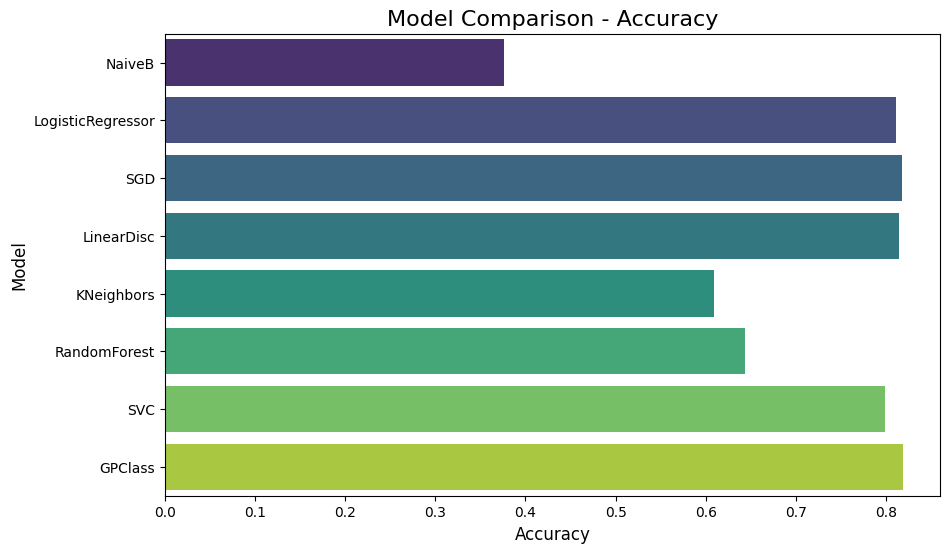

In [6]:
import seaborn as sns
model_names = label_models  # List of model names (as in your code)
model_scores = []  # To store the best score (accuracy) for each model

# Extract the best scorecand best params for each model from the GridSearchCV results
for i in range(len(models)):
    best_score = models[i].best_score_  # Best score from cross-validation
    best_params = models[i].best_params_
    print("Mejores hiperparámetros del modelo ",model_names[i],":", best_params)
    print("Mejor puntaje del modelo ",model_names[i],":", best_score)
    model_scores.append(best_score)

# Create a DataFrame for better plotting
import pandas as pd
results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': model_scores
})

# Plot the comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')

# Add titles and labels
plt.title('Model Comparison - Accuracy', fontsize=16)
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Model', fontsize=12)

# Show plot
plt.show()

**Evaluacion y matrices de confusion**

Evaluando modelo NaiveB (1/8)


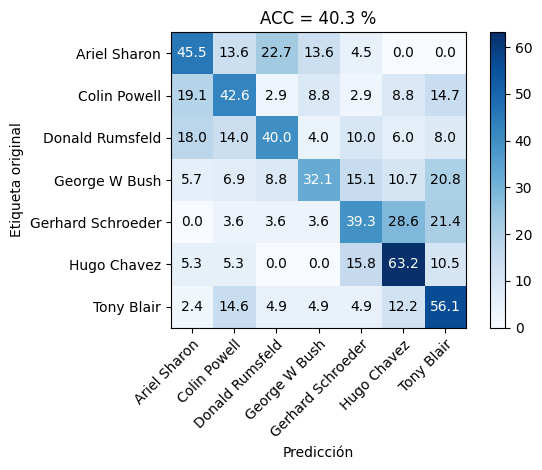

                   precision    recall  f1-score   support

     Ariel Sharon       0.23      0.45      0.31        22
     Colin Powell       0.50      0.43      0.46        68
  Donald Rumsfeld       0.45      0.40      0.43        50
    George W Bush       0.78      0.32      0.46       159
Gerhard Schroeder       0.23      0.39      0.29        28
      Hugo Chavez       0.24      0.63      0.34        19
       Tony Blair       0.29      0.56      0.39        41

         accuracy                           0.40       387
        macro avg       0.39      0.46      0.38       387
     weighted avg       0.54      0.40      0.42       387

Evaluando modelo LogisticRegressor (2/8)


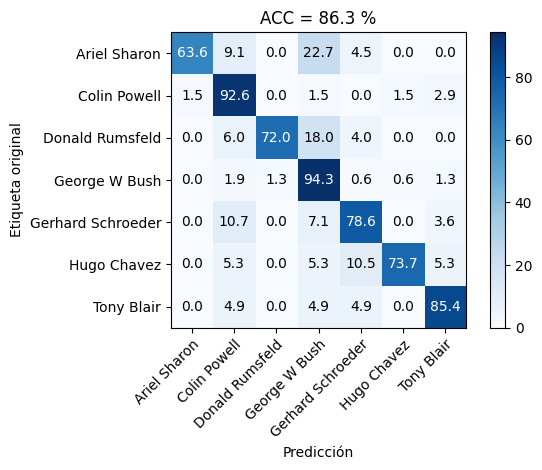

                   precision    recall  f1-score   support

     Ariel Sharon       0.93      0.64      0.76        22
     Colin Powell       0.82      0.93      0.87        68
  Donald Rumsfeld       0.95      0.72      0.82        50
    George W Bush       0.88      0.94      0.91       159
Gerhard Schroeder       0.73      0.79      0.76        28
      Hugo Chavez       0.88      0.74      0.80        19
       Tony Blair       0.85      0.85      0.85        41

         accuracy                           0.86       387
        macro avg       0.86      0.80      0.82       387
     weighted avg       0.87      0.86      0.86       387

Evaluando modelo SGD (3/8)


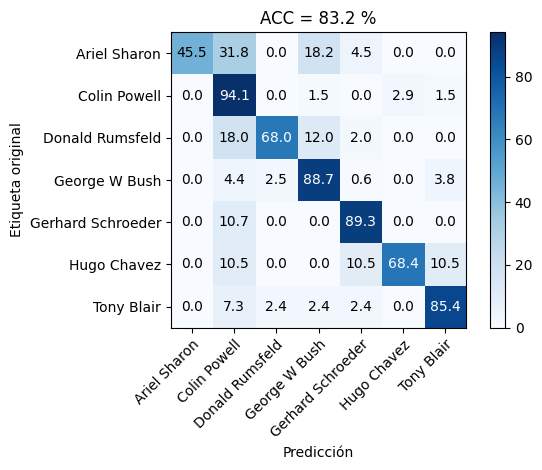

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.45      0.62        22
     Colin Powell       0.67      0.94      0.79        68
  Donald Rumsfeld       0.87      0.68      0.76        50
    George W Bush       0.92      0.89      0.90       159
Gerhard Schroeder       0.81      0.89      0.85        28
      Hugo Chavez       0.87      0.68      0.76        19
       Tony Blair       0.80      0.85      0.82        41

         accuracy                           0.83       387
        macro avg       0.85      0.77      0.79       387
     weighted avg       0.85      0.83      0.83       387

Evaluando modelo LinearDisc (4/8)


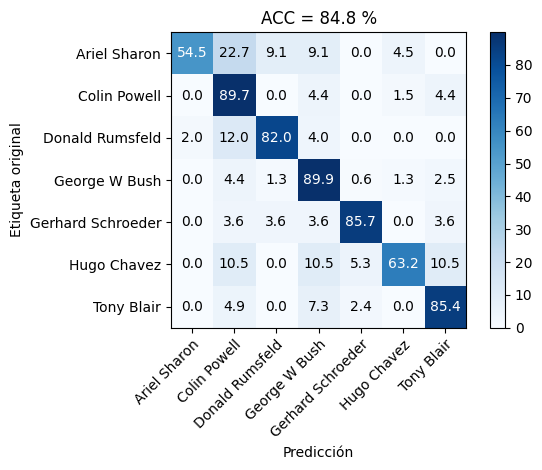

                   precision    recall  f1-score   support

     Ariel Sharon       0.92      0.55      0.69        22
     Colin Powell       0.73      0.90      0.80        68
  Donald Rumsfeld       0.89      0.82      0.85        50
    George W Bush       0.92      0.90      0.91       159
Gerhard Schroeder       0.89      0.86      0.87        28
      Hugo Chavez       0.75      0.63      0.69        19
       Tony Blair       0.78      0.85      0.81        41

         accuracy                           0.85       387
        macro avg       0.84      0.79      0.80       387
     weighted avg       0.86      0.85      0.85       387

Evaluando modelo KNeighbors (5/8)


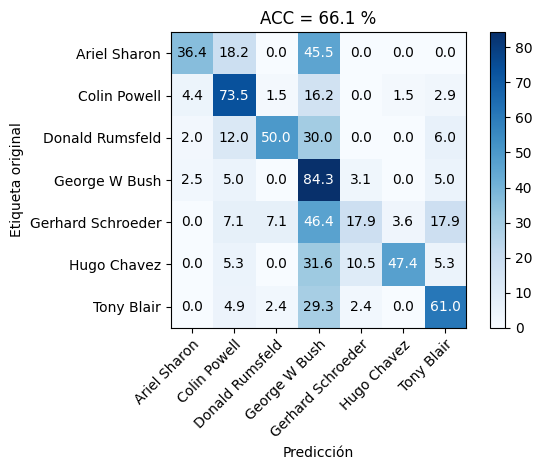

                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.36      0.42        22
     Colin Powell       0.68      0.74      0.71        68
  Donald Rumsfeld       0.86      0.50      0.63        50
    George W Bush       0.67      0.84      0.74       159
Gerhard Schroeder       0.38      0.18      0.24        28
      Hugo Chavez       0.82      0.47      0.60        19
       Tony Blair       0.57      0.61      0.59        41

         accuracy                           0.66       387
        macro avg       0.64      0.53      0.56       387
     weighted avg       0.66      0.66      0.65       387

Evaluando modelo RandomForest (6/8)


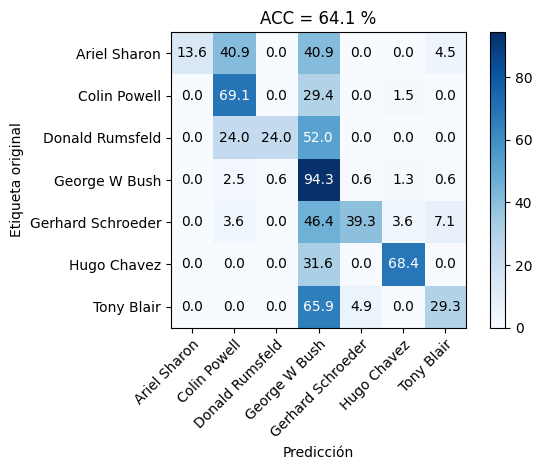

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.14      0.24        22
     Colin Powell       0.64      0.69      0.67        68
  Donald Rumsfeld       0.92      0.24      0.38        50
    George W Bush       0.60      0.94      0.73       159
Gerhard Schroeder       0.79      0.39      0.52        28
      Hugo Chavez       0.76      0.68      0.72        19
       Tony Blair       0.75      0.29      0.42        41

         accuracy                           0.64       387
        macro avg       0.78      0.48      0.53       387
     weighted avg       0.71      0.64      0.60       387

Evaluando modelo SVC (7/8)


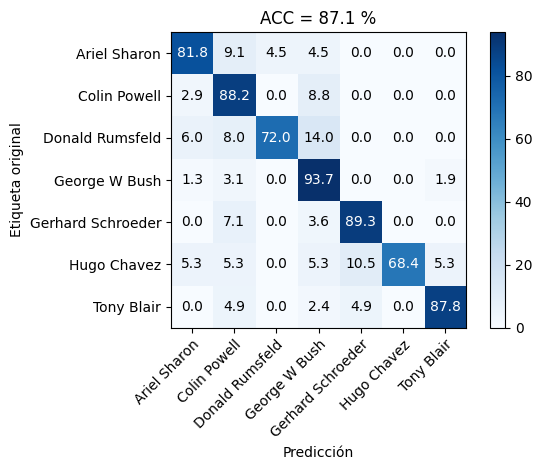

                   precision    recall  f1-score   support

     Ariel Sharon       0.69      0.82      0.75        22
     Colin Powell       0.79      0.88      0.83        68
  Donald Rumsfeld       0.97      0.72      0.83        50
    George W Bush       0.90      0.94      0.92       159
Gerhard Schroeder       0.86      0.89      0.88        28
      Hugo Chavez       1.00      0.68      0.81        19
       Tony Blair       0.90      0.88      0.89        41

         accuracy                           0.87       387
        macro avg       0.87      0.83      0.84       387
     weighted avg       0.88      0.87      0.87       387

Evaluando modelo GPClass (8/8)


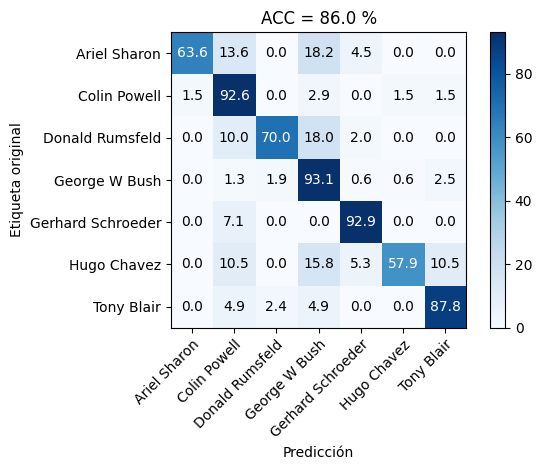

                   precision    recall  f1-score   support

     Ariel Sharon       0.93      0.64      0.76        22
     Colin Powell       0.80      0.93      0.86        68
  Donald Rumsfeld       0.90      0.70      0.79        50
    George W Bush       0.88      0.93      0.91       159
Gerhard Schroeder       0.87      0.93      0.90        28
      Hugo Chavez       0.85      0.58      0.69        19
       Tony Blair       0.84      0.88      0.86        41

         accuracy                           0.86       387
        macro avg       0.87      0.80      0.82       387
     weighted avg       0.86      0.86      0.86       387



In [7]:
#%% evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)

    plot_confusion_matrix(
                          ytest, ytest_e,
                          classes=lfw_people.target_names,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])
    plt.show()

    cr = classification_report(
                               ytest, ytest_e,
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )
    #support = #muestras en la clase estudiada
    print(cr)

* **2.2.2 Implementación de los modelos con f1 como score en el gridsearch**

In [8]:
models = []
filename = 'results/lfw_models_f1'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='f1_macro',refit= True,verbose=2)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

modelo 1/8
Fitting 5 folds for each of 5 candidates, totalling 25 fits
modelo 2/8
Fitting 5 folds for each of 30 candidates, totalling 150 fits
modelo 3/8
Fitting 5 folds for each of 810 candidates, totalling 4050 fits
modelo 4/8
Fitting 5 folds for each of 90 candidates, totalling 450 fits
modelo 5/8
Fitting 5 folds for each of 72 candidates, totalling 360 fits
modelo 6/8
Fitting 5 folds for each of 486 candidates, totalling 2430 fits
modelo 7/8
Fitting 5 folds for each of 520 candidates, totalling 2600 fits
modelo 8/8
Fitting 5 folds for each of 54 candidates, totalling 270 fits


**Scores en CV**

Mejores hiperparámetros del modelo  NaiveB : {'cla__var_smoothing': 1e-09}
Mejor puntaje del modelo  NaiveB : 0.34891677391317993
Mejores hiperparámetros del modelo  LogisticRegressor : {'cla__C': 1, 'cla__class_weight': 'balanced', 'cla__l1_ratio': 0.2, 'cla__penalty': 'elasticnet', 'cla__solver': 'saga'}
Mejor puntaje del modelo  LogisticRegressor : 0.7770641707006366
Mejores hiperparámetros del modelo  SGD : {'cla__alpha': 0.001, 'cla__class_weight': 'balanced', 'cla__eta0': 0.1, 'cla__l1_ratio': 0.7, 'cla__learning_rate': 'invscaling', 'cla__loss': 'hinge', 'cla__penalty': 'elasticnet'}
Mejor puntaje del modelo  SGD : 0.7693917954085786
Mejores hiperparámetros del modelo  LinearDisc : {'cla__n_components': None, 'cla__priors': array([0.05512422, 0.11180124, 0.41149068, 0.18322981, 0.05978261,
       0.08462733, 0.0939441 ]), 'cla__shrinkage': 'auto', 'cla__solver': 'lsqr'}
Mejor puntaje del modelo  LinearDisc : 0.7756928217295748
Mejores hiperparámetros del modelo  KNeighbors : {'c

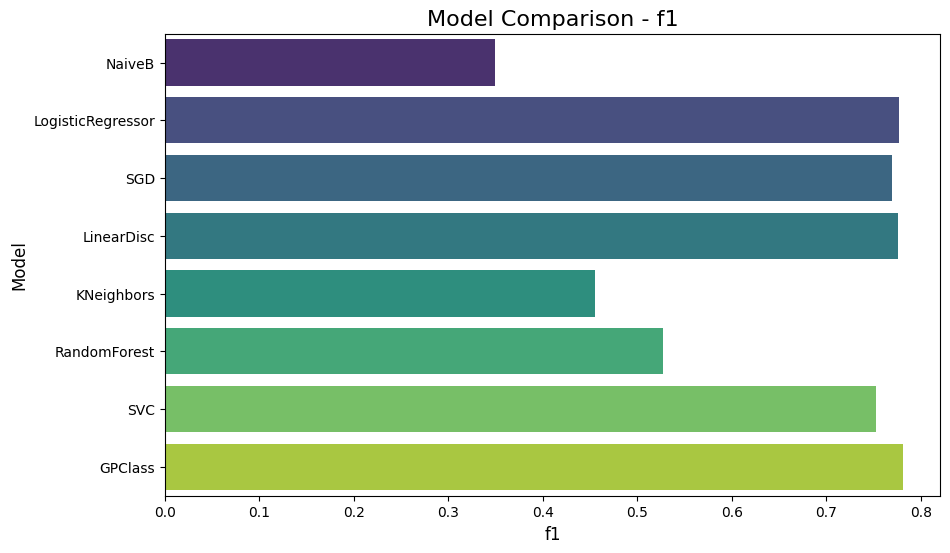

In [9]:
import seaborn as sns

model_names = label_models  # List of model names (as in your code)
model_scores = []  # To store the best score for each model

# Extract the best scorecand best params for each model from the GridSearchCV results
for i in range(len(models)):
    best_score = models[i].best_score_  # Best score from cross-validation
    best_params = models[i].best_params_
    print("Mejores hiperparámetros del modelo ",model_names[i],":", best_params)
    print("Mejor puntaje del modelo ",model_names[i],":", best_score)
    model_scores.append(best_score)

# Create a DataFrame for better plotting
import pandas as pd
results_df = pd.DataFrame({
    'Model': model_names,
    'f1': model_scores
})

# Plot the comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='f1', y='Model', data=results_df, palette='viridis')

# Add titles and labels
plt.title('Model Comparison - f1', fontsize=16)
plt.xlabel('f1', fontsize=12)
plt.ylabel('Model', fontsize=12)

# Show plot
plt.show()

**Evaluiacion y matrices de confusion**

results/lfw_models_f1
Evaluando modelo NaiveB (1/8)


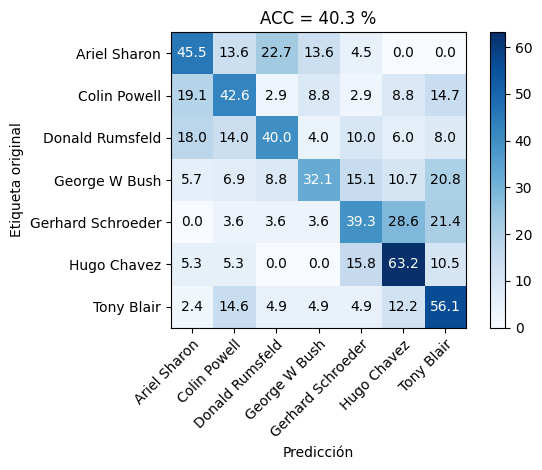

                   precision    recall  f1-score   support

     Ariel Sharon       0.23      0.45      0.31        22
     Colin Powell       0.50      0.43      0.46        68
  Donald Rumsfeld       0.45      0.40      0.43        50
    George W Bush       0.78      0.32      0.46       159
Gerhard Schroeder       0.23      0.39      0.29        28
      Hugo Chavez       0.24      0.63      0.34        19
       Tony Blair       0.29      0.56      0.39        41

         accuracy                           0.40       387
        macro avg       0.39      0.46      0.38       387
     weighted avg       0.54      0.40      0.42       387

Evaluando modelo LogisticRegressor (2/8)


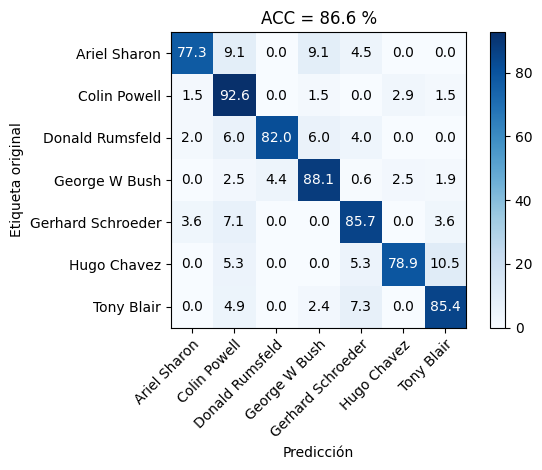

                   precision    recall  f1-score   support

     Ariel Sharon       0.85      0.77      0.81        22
     Colin Powell       0.82      0.93      0.87        68
  Donald Rumsfeld       0.85      0.82      0.84        50
    George W Bush       0.95      0.88      0.92       159
Gerhard Schroeder       0.75      0.86      0.80        28
      Hugo Chavez       0.71      0.79      0.75        19
       Tony Blair       0.83      0.85      0.84        41

         accuracy                           0.87       387
        macro avg       0.82      0.84      0.83       387
     weighted avg       0.87      0.87      0.87       387

Evaluando modelo SGD (3/8)


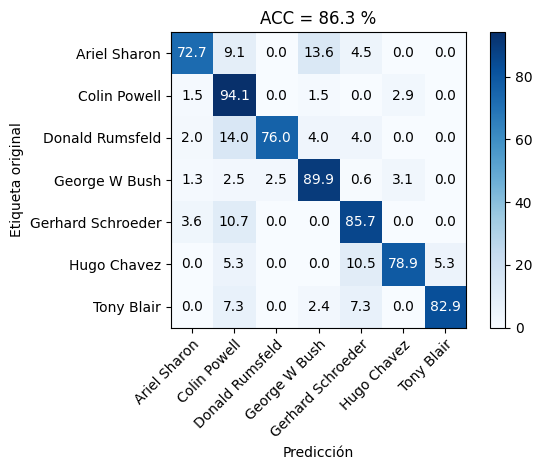

                   precision    recall  f1-score   support

     Ariel Sharon       0.76      0.73      0.74        22
     Colin Powell       0.76      0.94      0.84        68
  Donald Rumsfeld       0.90      0.76      0.83        50
    George W Bush       0.95      0.90      0.93       159
Gerhard Schroeder       0.73      0.86      0.79        28
      Hugo Chavez       0.68      0.79      0.73        19
       Tony Blair       0.97      0.83      0.89        41

         accuracy                           0.86       387
        macro avg       0.82      0.83      0.82       387
     weighted avg       0.87      0.86      0.86       387

Evaluando modelo LinearDisc (4/8)


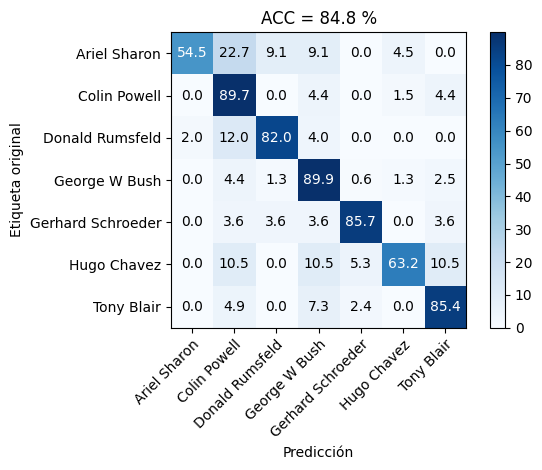

                   precision    recall  f1-score   support

     Ariel Sharon       0.92      0.55      0.69        22
     Colin Powell       0.73      0.90      0.80        68
  Donald Rumsfeld       0.89      0.82      0.85        50
    George W Bush       0.92      0.90      0.91       159
Gerhard Schroeder       0.89      0.86      0.87        28
      Hugo Chavez       0.75      0.63      0.69        19
       Tony Blair       0.78      0.85      0.81        41

         accuracy                           0.85       387
        macro avg       0.84      0.79      0.80       387
     weighted avg       0.86      0.85      0.85       387

Evaluando modelo KNeighbors (5/8)


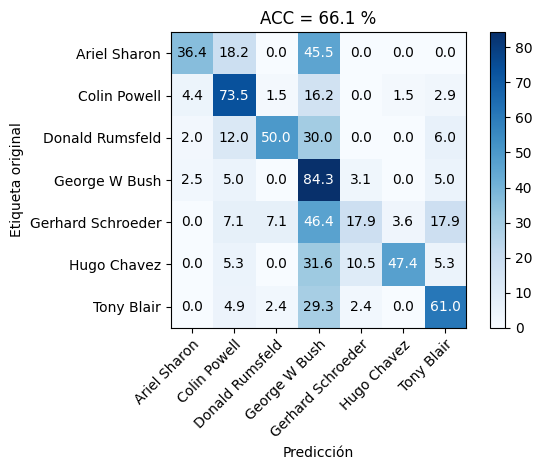

                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.36      0.42        22
     Colin Powell       0.68      0.74      0.71        68
  Donald Rumsfeld       0.86      0.50      0.63        50
    George W Bush       0.67      0.84      0.74       159
Gerhard Schroeder       0.38      0.18      0.24        28
      Hugo Chavez       0.82      0.47      0.60        19
       Tony Blair       0.57      0.61      0.59        41

         accuracy                           0.66       387
        macro avg       0.64      0.53      0.56       387
     weighted avg       0.66      0.66      0.65       387

Evaluando modelo RandomForest (6/8)


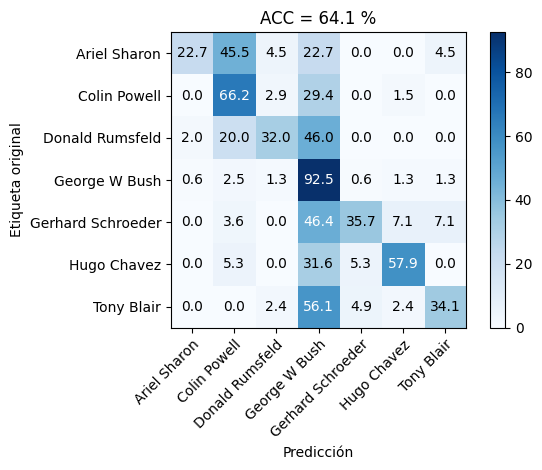

                   precision    recall  f1-score   support

     Ariel Sharon       0.71      0.23      0.34        22
     Colin Powell       0.63      0.66      0.65        68
  Donald Rumsfeld       0.73      0.32      0.44        50
    George W Bush       0.62      0.92      0.74       159
Gerhard Schroeder       0.71      0.36      0.48        28
      Hugo Chavez       0.65      0.58      0.61        19
       Tony Blair       0.74      0.34      0.47        41

         accuracy                           0.64       387
        macro avg       0.68      0.49      0.53       387
     weighted avg       0.66      0.64      0.61       387

Evaluando modelo SVC (7/8)


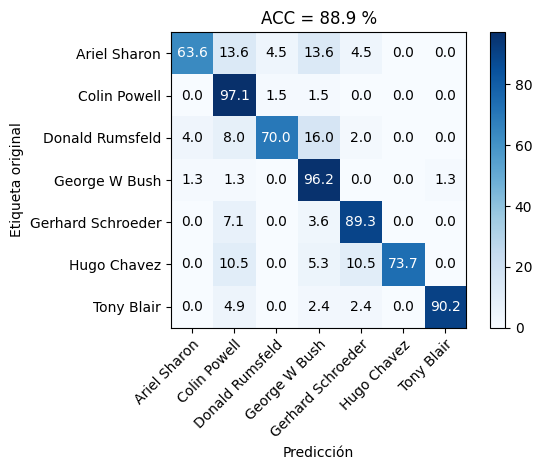

                   precision    recall  f1-score   support

     Ariel Sharon       0.78      0.64      0.70        22
     Colin Powell       0.81      0.97      0.89        68
  Donald Rumsfeld       0.95      0.70      0.80        50
    George W Bush       0.91      0.96      0.94       159
Gerhard Schroeder       0.83      0.89      0.86        28
      Hugo Chavez       1.00      0.74      0.85        19
       Tony Blair       0.95      0.90      0.92        41

         accuracy                           0.89       387
        macro avg       0.89      0.83      0.85       387
     weighted avg       0.89      0.89      0.89       387

Evaluando modelo GPClass (8/8)


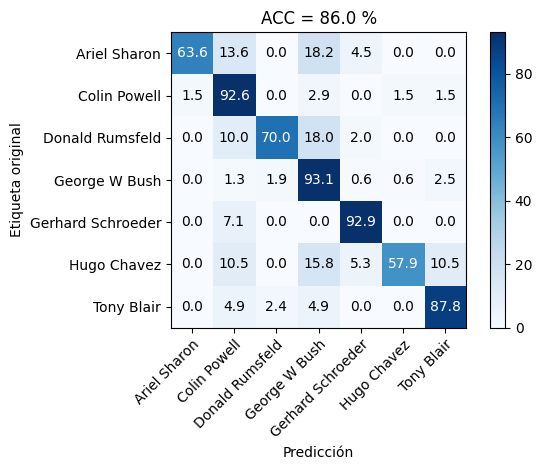

                   precision    recall  f1-score   support

     Ariel Sharon       0.93      0.64      0.76        22
     Colin Powell       0.80      0.93      0.86        68
  Donald Rumsfeld       0.90      0.70      0.79        50
    George W Bush       0.88      0.93      0.91       159
Gerhard Schroeder       0.87      0.93      0.90        28
      Hugo Chavez       0.85      0.58      0.69        19
       Tony Blair       0.84      0.88      0.86        41

         accuracy                           0.86       387
        macro avg       0.87      0.80      0.82       387
     weighted avg       0.86      0.86      0.86       387



In [10]:
#%% evaluar sobre Xtest
print(filename)
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)

    plot_confusion_matrix(
                          ytest, ytest_e,
                          classes=lfw_people.target_names,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])
    plt.show()

    cr = classification_report(
                               ytest, ytest_e,
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )
    #support = #muestras en la clase estudiada
    print(cr)

* **2.2.3 PCA y UMAP**

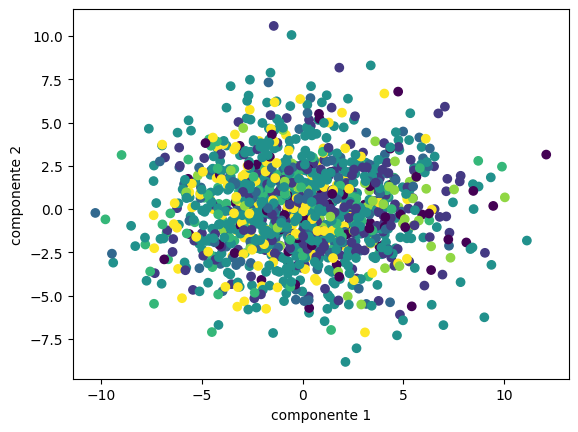

In [11]:
from sklearn.decomposition import PCA
scaler = MinMaxScaler()
data = scaler.fit_transform(Xdata)
pca = PCA(n_components = 2)
Y2D = pca.fit_transform(data)
plt.scatter(Y2D[:,0],Y2D[:,1],c=y)
plt.xlabel('componente 1')
plt.ylabel('componente 2')
plt.show()

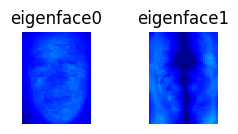

In [12]:
pca = PCA(n_components = 0.99)
Y2D = pca.fit_transform(data)
n_rows = 1
n_cols = 2
plt.figure(figsize=(n_cols * 1.5, n_rows * 1.2))
#resolución imagenes
img_w = 50
img_h = 37

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(abs(pca.components_[index].reshape(img_w,img_h)),
                    vmin=abs(pca.components_).min(), vmax=abs(pca.components_).max(),cmap="jet", interpolation="nearest")
        plt.axis('off')
        plt.title("eigenface" + str(index), fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [13]:
!pip install umap-learn #librería umap
!pip install datashader bokeh holoviews #gráficos umap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.1 MB/s eta 0:00:00


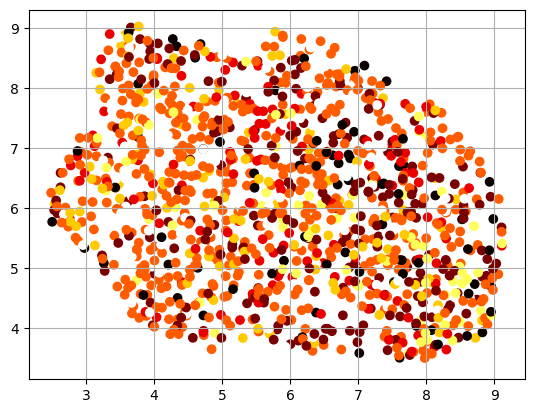

In [14]:
import umap
import umap.plot

red = umap.UMAP(n_components=2,n_neighbors=40, min_dist=0.2)
X_reduced_umap = red.fit_transform(data)
plt.scatter(X_reduced_umap[:, 0], X_reduced_umap[:, 1], c=y, cmap=plt.cm.hot)
plt.grid(True)
plt.show()